<a href="https://colab.research.google.com/github/c-vaughan-ai/Kaggle_ISLR/blob/main/Kaggle_ISLR_Resume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google ISLR Competition

Connor Vaughan

This notebook is a solution to the Kaggle Google - Isolated Sign Language Recognition competition.

The goal is to be able to train a machine learning model to predict signs, based on landmark index coordinates. The original data is from videos of people demonstrating certain signs, that has been converted into the landmark indexes. The competition page can be found here: https://www.kaggle.com/competitions/asl-signs/overview

In [1]:
# Make Sure Kaggle is installed
! pip install kaggle

In [2]:
# Create a directory and download the competition dataset
# You will need to make sure you have your Kaggle API json file loaded into your environment
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c asl-signs
! mkdir Data
! unzip asl-signs.zip -d Data

Streaming output truncated to the last 5000 lines.
  inflating: Data/train_landmark_files/61333/644240510.parquet  
  inflating: Data/train_landmark_files/61333/644760785.parquet  
  inflating: Data/train_landmark_files/61333/64714634.parquet  
  inflating: Data/train_landmark_files/61333/647782358.parquet  
  inflating: Data/train_landmark_files/61333/647894613.parquet  
  inflating: Data/train_landmark_files/61333/648219958.parquet  
  inflating: Data/train_landmark_files/61333/648759798.parquet  
  inflating: Data/train_landmark_files/61333/648810695.parquet  
  inflating: Data/train_landmark_files/61333/649793223.parquet  
  inflating: Data/train_landmark_files/61333/650186126.parquet  
  inflating: Data/train_landmark_files/61333/650848108.parquet  
  inflating: Data/train_landmark_files/61333/653707084.parquet  
  inflating: Data/train_landmark_files/61333/653782862.parquet  
  inflating: Data/train_landmark_files/61333/65568424.parquet  
  inflating: Data/train_landmark_files/61

In [3]:
# The model will use AdamW as it's optimizer which is only found in the tensorflow addons
! pip install tensorflow_addons

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import json
import os
import gc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
from  google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the train csv file
train = pd.read_csv(f"/content/Data/train.csv")
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [7]:
# Group the dataframe by signs and count the number of occurrences
sign_counts = train.groupby('sign').size().reset_index(name='count')
print(f"Number of signs to predict: {len(sign_counts)}")

min_sign = sign_counts.loc[sign_counts['count'].idxmin()]
print(f"Minimum number of samples for a sign: {min_sign}")

max_sign = sign_counts.loc[sign_counts['count'].idxmax()]
print(f"Maximum number of samples for a sign: {max_sign}")

avg_sign = sign_counts['count'].mean()
print(f"Average number of samples of signs: {avg_sign}")

Number of signs to predict: 250
Minimum number of samples for a sign: sign     zipper
count       299
Name: 249, dtype: object
Maximum number of samples for a sign: sign     listen
count       415
Name: 135, dtype: object
Average number of samples of signs: 377.908


Next let's look at some sample parquet files. The competition has the following descriptions of the parquet files:

frame - The frame number in the raw video.

row_id - A unique identifier for the row.

type - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
landmark_index - The landmark index number. Details of the hand landmark  locations can be found here.

[x/y/z] - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

The data is labeled landmark data extracted using the MediaPipe Holistic Solution. The way I think about this data is as a video, with the key features already extracted. We will then use this "video" the predict what sign is being displayed.

In [8]:
# Helper function - provided by the competition. This is how the data is loaded for inference
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / 543)
    data = data.values.reshape(n_frames, 543, len(data_columns))
    return data.astype(np.float32)

# Helper function to get stats about the dataset
def compute_dataset_stats(train_df):
  total_frames = 0
  total_missing_values = 0
  num_files = 0
  for i in tqdm(range(len(train_df))):
    path = os.path.join(root_path, train_df['path'].iloc[i])
    data = load_relevant_data_subset(path)
    num_frames = data.shape[0]
    total_frames += num_frames
    total_missing_values += np.isnan(data).sum()
    num_files += 1
  avg_frames = total_frames / num_files
  avg_missing_values = total_missing_values / (total_frames * 3)
  return avg_frames, avg_missing_values

In [9]:
# Load a sample file
sample = load_relevant_data_subset('/content/Data/train_landmark_files/16069/100015657.parquet')
print("Shape of this sample:", sample.shape)
print("Number of missing values", np.isnan(sample).sum())

Shape of this sample: (105, 543, 3)
Number of missing values 11466


In [10]:
#Average number frames and missing values
root_path = '/content/Data/'
avg_frames, avg_missing_values = compute_dataset_stats(train)
print(avg_frames, avg_missing_values)

100%|██████████| 94477/94477 [10:52<00:00, 144.76it/s]

37.93502122209638 32.315948132624364


Looking at the data we can see there are variable number of frames. To handle for this we can either reshape the data to a fixed length or PAD the data. If we were to PAD the data we would add masking to the model. For this model we are going to reshape to a fixed length.

It's also important to note there is a fair amount of missing data. Imputing these missing values will be a key part of this competition. For this model, we will be replacing the missing values with the average values of each landmark feature column.

The data for the Z data column will be dropeed as testing shows no accuracy improvement when included.

To better understand the competition, it's helpful to visualize a sample "video." The below code is taken from DANIELPESHKOV's Kaggle Notebook at the below link.

https://www.kaggle.com/code/danielpeshkov/animated-data-visualization

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [12]:
## Change this directory to any file
dir = '/content/Data/'

path_to_sign = 'train_landmark_files/16069/100015657.parquet'
sign = pd.read_parquet(f'{dir}{path_to_sign}')
sign.y = sign.y * -1

In [13]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

The sign being shown here is: cloud


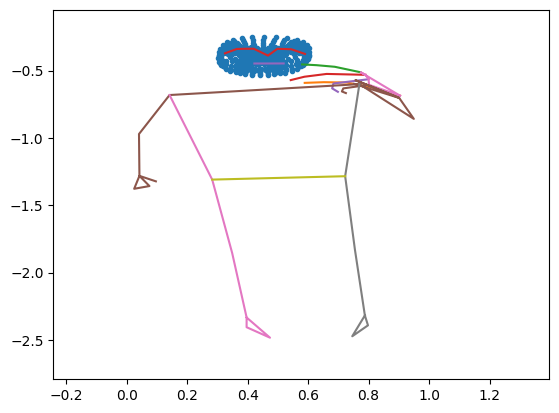

In [14]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

print(f"The sign being shown here is: {train[train.path==f'{path_to_sign}'].sign.values[0]}")

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())

In [15]:
# Add a label column to train based on the sign column
def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

label_index = read_dict(f"/content/Data/sign_to_prediction_index_map.json")
index_label = dict([(label_index[key], key) for key in label_index])
print(label_index)
train["label"] = train["sign"].map(lambda sign: label_index[sign])
train.head()

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

,path,participant_id,sequence_id,sign,label
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


The pre-processing of the data is done in a separate notebook that can be found here.

Below is a summary of the pre-rpcessing steps


1.   Drop Z axis as testing revealed it does not provide higher accuracies.
2.   Normalize to a common mean
3.   Normalize to a commone standard deviation
4.   Replace nan with mean for each feature column
5.   Reshape so each sample has the same number of frames



In [16]:
# Load the data created in the pre-processing notebook

X_train = np.load('/content/drive/My Drive/Kaggle ISLR/X_train_20.543.2.npy')
y_train = np.load('/content/drive/My Drive/Kaggle ISLR/y_train_20.543.2.npy')
print(X_train.shape)
print(y_train.shape)

(94477, 20, 543, 2)
(94477,)


The next few cells create a few helper functions for training

In [17]:
_num_classes = 250

# Label smoothing for sparse categorical crossentropy(penalizes over confidence)
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, _num_classes, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

In [18]:
# Custom callback to update weight decay with learning rate
_wd_ratio = 0.05
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=_wd_ratio):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

In [19]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=15):

    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [20]:
# Learning Rate
_lr_max = 1e-3
# Number of warm-up epochs
_n_warmup_epochs = 0

import math
_n_epochs = 100

# Learning rate for encoder
lr_schedule = [lrfn(step, num_warmup_steps=_n_warmup_epochs, lr_max=_lr_max, num_cycles=0.50) for step in range(_n_epochs)]

# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lr_schedule[step], verbose=1)

Given the context of the data being frames of a video, I've seen a lot of people use Conv1d models for this competition. However, I will be using Conv2d for this model. The idea behind this is that there are important relationships between the features of each landmark feature(column of data), that would be lost in a Conv1d model.

There are numerous Conv2d architectures to choose from, I am starting with Resnet18 as a baseline.

This does take quite some time to train due to there being 250 classes. My approach to be able to test various models and ideas quickly was to train on a reduced dataset of only 50 classes. Below I'm loading one of the pretrained models on 50 classes and replacing the last dense layer with an output of 250 to retrain for all 250 classes.

In [21]:
load_model = tf.keras.models.load_model('best_resnet_model1_conv2d_v16.h5')

# Create a new output layer with 250 units
new_output_layer = tf.keras.layers.Dense(units=250, activation='softmax', name='densse')(load_model.layers[-2].output)

# Create a new model that includes the pre-trained model and the new output layer
model = tf.keras.Model(inputs=load_model.input, outputs=new_output_layer)

# Sparse Categorical Cross Entropy With Label Smoothing
loss = scce_with_ls

# Adam Optimizer with weight decay
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)

# TopK Metrics
metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
]

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 543, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 10, 272, 64)  6336        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 272, 64)  256        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [23]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

class MyDataGenerator(Sequence):

    def __init__(self, data, labels, batch_size=32, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.data[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]

        # Pad or truncate the input sequences to a fixed length of 20 ()
        batch_data = pad_sequences(batch_data, maxlen=40, dtype='float32', padding='post', truncating='post', value=0.0)

        return np.array(batch_data), np.array(batch_labels)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [24]:
batch_size = 32
first_dim = 40
train_gen = MyDataGenerator(X_train, y_train, batch_size, first_dim)
val_gen = MyDataGenerator(X_val, y_val, batch_size, first_dim)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'best_cnn_model_resnet_v17.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [26]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint_callback,
               #lr_callback,
               #WeightDecayCallback()
               ]
)

Epoch 1/50
2362/2362 [==============================] - ETA: 0s - loss: 4.5337 - acc: 0.1624 - top_5_acc: 0.4254 - top_10_acc: 0.5552

2362/2362 [==============================] - 61s 22ms/step - loss: 4.5337 - acc: 0.1624 - top_5_acc: 0.4254 - top_10_acc: 0.5552 - val_loss: 4.0926 - val_acc: 0.2678 - val_top_5_acc: 0.6104 - val_top_10_acc: 0.7410
Epoch 2/50
2360/2362 [============================>.] - ETA: 0s - loss: 4.0572 - acc: 0.2776 - top_5_acc: 0.6137 - top_10_acc: 0.7395

2362/2362 [==============================] - 51s 22ms/step - loss: 4.0573 - acc: 0.2776 - top_5_acc: 0.6137 - top_10_acc: 0.7396 - val_loss: 3.9540 - val_acc: 0.3079 - val_top_5_acc: 0.6441 - val_top_10_acc: 0.7653
Epoch 3/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.9122 - acc: 0.3257 - top_5_acc: 0.6602 - top_10_acc: 0.7783

2362/2362 [==============================] - 51s 22ms/step - loss: 3.9121 - acc: 0.3257 - top_5_acc: 0.6602 - top_10_acc: 0.7783 - val_loss: 3.8773 - val_acc: 0.3399 - val_top_5_acc: 0.6709 - val_top_10_acc: 0.7776
Epoch 4/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.8199 - acc: 0.3550 - top_5_acc: 0.6901 - top_10_acc: 0.7963

2362/2362 [==============================] - 51s 22ms/step - loss: 3.8200 - acc: 0.3550 - top_5_acc: 0.6900 - top_10_acc: 0.7962 - val_loss: 3.8244 - val_acc: 0.3531 - val_top_5_acc: 0.6822 - val_top_10_acc: 0.7860
Epoch 5/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.7535 - acc: 0.3777 - top_5_acc: 0.7074 - top_10_acc: 0.8087

2362/2362 [==============================] - 51s 22ms/step - loss: 3.7535 - acc: 0.3778 - top_5_acc: 0.7075 - top_10_acc: 0.8087 - val_loss: 3.8341 - val_acc: 0.3507 - val_top_5_acc: 0.6768 - val_top_10_acc: 0.7837
Epoch 6/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.7001 - acc: 0.3974 - top_5_acc: 0.7220 - top_10_acc: 0.8185

2362/2362 [==============================] - 51s 22ms/step - loss: 3.7001 - acc: 0.3974 - top_5_acc: 0.7220 - top_10_acc: 0.8185 - val_loss: 3.7770 - val_acc: 0.3645 - val_top_5_acc: 0.6872 - val_top_10_acc: 0.7923
Epoch 7/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.6551 - acc: 0.4117 - top_5_acc: 0.7342 - top_10_acc: 0.8266

2362/2362 [==============================] - 51s 22ms/step - loss: 3.6551 - acc: 0.4118 - top_5_acc: 0.7342 - top_10_acc: 0.8266 - val_loss: 3.7349 - val_acc: 0.3770 - val_top_5_acc: 0.7040 - val_top_10_acc: 0.8040
Epoch 8/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.6181 - acc: 0.4258 - top_5_acc: 0.7436 - top_10_acc: 0.8329

2362/2362 [==============================] - 51s 22ms/step - loss: 3.6182 - acc: 0.4258 - top_5_acc: 0.7435 - top_10_acc: 0.8329 - val_loss: 3.6744 - val_acc: 0.4053 - val_top_5_acc: 0.7171 - val_top_10_acc: 0.8093
Epoch 9/50
2362/2362 [==============================] - ETA: 0s - loss: 3.5842 - acc: 0.4381 - top_5_acc: 0.7522 - top_10_acc: 0.8398

2362/2362 [==============================] - 51s 21ms/step - loss: 3.5842 - acc: 0.4381 - top_5_acc: 0.7522 - top_10_acc: 0.8398 - val_loss: 3.7219 - val_acc: 0.3965 - val_top_5_acc: 0.7088 - val_top_10_acc: 0.8048
Epoch 10/50
2362/2362 [==============================] - ETA: 0s - loss: 3.5592 - acc: 0.4486 - top_5_acc: 0.7600 - top_10_acc: 0.8437

2362/2362 [==============================] - 51s 22ms/step - loss: 3.5592 - acc: 0.4486 - top_5_acc: 0.7600 - top_10_acc: 0.8437 - val_loss: 3.6195 - val_acc: 0.4258 - val_top_5_acc: 0.7353 - val_top_10_acc: 0.8209
Epoch 11/50
2362/2362 [==============================] - ETA: 0s - loss: 3.5320 - acc: 0.4574 - top_5_acc: 0.7664 - top_10_acc: 0.8475

2362/2362 [==============================] - 51s 21ms/step - loss: 3.5320 - acc: 0.4574 - top_5_acc: 0.7664 - top_10_acc: 0.8475 - val_loss: 3.5597 - val_acc: 0.4490 - val_top_5_acc: 0.7540 - val_top_10_acc: 0.8340
Epoch 12/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.5076 - acc: 0.4661 - top_5_acc: 0.7744 - top_10_acc: 0.8538

2362/2362 [==============================] - 51s 21ms/step - loss: 3.5075 - acc: 0.4662 - top_5_acc: 0.7744 - top_10_acc: 0.8538 - val_loss: 3.6152 - val_acc: 0.4273 - val_top_5_acc: 0.7354 - val_top_10_acc: 0.8229
Epoch 13/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.4885 - acc: 0.4742 - top_5_acc: 0.7778 - top_10_acc: 0.8556

2362/2362 [==============================] - 51s 22ms/step - loss: 3.4885 - acc: 0.4742 - top_5_acc: 0.7778 - top_10_acc: 0.8556 - val_loss: 3.5583 - val_acc: 0.4495 - val_top_5_acc: 0.7493 - val_top_10_acc: 0.8306
Epoch 14/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.4714 - acc: 0.4800 - top_5_acc: 0.7824 - top_10_acc: 0.8584

2362/2362 [==============================] - 50s 21ms/step - loss: 3.4713 - acc: 0.4801 - top_5_acc: 0.7825 - top_10_acc: 0.8584 - val_loss: 3.6811 - val_acc: 0.4087 - val_top_5_acc: 0.7192 - val_top_10_acc: 0.8117
Epoch 15/50
2362/2362 [==============================] - ETA: 0s - loss: 3.4533 - acc: 0.4860 - top_5_acc: 0.7872 - top_10_acc: 0.8621

2362/2362 [==============================] - 50s 21ms/step - loss: 3.4533 - acc: 0.4860 - top_5_acc: 0.7872 - top_10_acc: 0.8621 - val_loss: 3.5390 - val_acc: 0.4540 - val_top_5_acc: 0.7542 - val_top_10_acc: 0.8345
Epoch 16/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.4331 - acc: 0.4951 - top_5_acc: 0.7919 - top_10_acc: 0.8656

2362/2362 [==============================] - 51s 21ms/step - loss: 3.4333 - acc: 0.4950 - top_5_acc: 0.7918 - top_10_acc: 0.8655 - val_loss: 3.5264 - val_acc: 0.4593 - val_top_5_acc: 0.7586 - val_top_10_acc: 0.8350
Epoch 17/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.4192 - acc: 0.4963 - top_5_acc: 0.7945 - top_10_acc: 0.8672

2362/2362 [==============================] - 51s 21ms/step - loss: 3.4192 - acc: 0.4963 - top_5_acc: 0.7945 - top_10_acc: 0.8672 - val_loss: 3.4818 - val_acc: 0.4762 - val_top_5_acc: 0.7730 - val_top_10_acc: 0.8444
Epoch 18/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.4027 - acc: 0.5058 - top_5_acc: 0.7985 - top_10_acc: 0.8685

2362/2362 [==============================] - 51s 22ms/step - loss: 3.4026 - acc: 0.5058 - top_5_acc: 0.7985 - top_10_acc: 0.8685 - val_loss: 3.4894 - val_acc: 0.4766 - val_top_5_acc: 0.7661 - val_top_10_acc: 0.8426
Epoch 19/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.3878 - acc: 0.5096 - top_5_acc: 0.8035 - top_10_acc: 0.8733

2362/2362 [==============================] - 51s 22ms/step - loss: 3.3879 - acc: 0.5096 - top_5_acc: 0.8035 - top_10_acc: 0.8733 - val_loss: 3.4567 - val_acc: 0.4849 - val_top_5_acc: 0.7765 - val_top_10_acc: 0.8513
Epoch 20/50
2362/2362 [==============================] - ETA: 0s - loss: 3.3750 - acc: 0.5121 - top_5_acc: 0.8060 - top_10_acc: 0.8737

2362/2362 [==============================] - 51s 22ms/step - loss: 3.3750 - acc: 0.5121 - top_5_acc: 0.8060 - top_10_acc: 0.8737 - val_loss: 3.4450 - val_acc: 0.4861 - val_top_5_acc: 0.7797 - val_top_10_acc: 0.8519
Epoch 21/50
2362/2362 [==============================] - ETA: 0s - loss: 3.3671 - acc: 0.5183 - top_5_acc: 0.8079 - top_10_acc: 0.8745

2362/2362 [==============================] - 51s 21ms/step - loss: 3.3671 - acc: 0.5183 - top_5_acc: 0.8079 - top_10_acc: 0.8745 - val_loss: 3.5090 - val_acc: 0.4695 - val_top_5_acc: 0.7600 - val_top_10_acc: 0.8359
Epoch 22/50
2362/2362 [==============================] - ETA: 0s - loss: 3.3568 - acc: 0.5248 - top_5_acc: 0.8082 - top_10_acc: 0.8759

2362/2362 [==============================] - 51s 21ms/step - loss: 3.3568 - acc: 0.5248 - top_5_acc: 0.8082 - top_10_acc: 0.8759 - val_loss: 3.5209 - val_acc: 0.4654 - val_top_5_acc: 0.7583 - val_top_10_acc: 0.8359
Epoch 23/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.3407 - acc: 0.5288 - top_5_acc: 0.8138 - top_10_acc: 0.8788

2362/2362 [==============================] - 51s 22ms/step - loss: 3.3407 - acc: 0.5288 - top_5_acc: 0.8138 - top_10_acc: 0.8788 - val_loss: 3.4370 - val_acc: 0.4972 - val_top_5_acc: 0.7813 - val_top_10_acc: 0.8544
Epoch 24/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.3297 - acc: 0.5329 - top_5_acc: 0.8165 - top_10_acc: 0.8804

2362/2362 [==============================] - 53s 22ms/step - loss: 3.3297 - acc: 0.5328 - top_5_acc: 0.8165 - top_10_acc: 0.8805 - val_loss: 3.4773 - val_acc: 0.4879 - val_top_5_acc: 0.7726 - val_top_10_acc: 0.8425
Epoch 25/50
2362/2362 [==============================] - ETA: 0s - loss: 3.3214 - acc: 0.5353 - top_5_acc: 0.8178 - top_10_acc: 0.8815

2362/2362 [==============================] - 53s 22ms/step - loss: 3.3214 - acc: 0.5353 - top_5_acc: 0.8178 - top_10_acc: 0.8815 - val_loss: 3.4135 - val_acc: 0.5131 - val_top_5_acc: 0.7849 - val_top_10_acc: 0.8546
Epoch 26/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.3094 - acc: 0.5395 - top_5_acc: 0.8203 - top_10_acc: 0.8840

2362/2362 [==============================] - 53s 22ms/step - loss: 3.3093 - acc: 0.5395 - top_5_acc: 0.8203 - top_10_acc: 0.8841 - val_loss: 3.4165 - val_acc: 0.5062 - val_top_5_acc: 0.7858 - val_top_10_acc: 0.8549
Epoch 27/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2982 - acc: 0.5441 - top_5_acc: 0.8243 - top_10_acc: 0.8867

2362/2362 [==============================] - 53s 22ms/step - loss: 3.2980 - acc: 0.5441 - top_5_acc: 0.8244 - top_10_acc: 0.8867 - val_loss: 3.4101 - val_acc: 0.5034 - val_top_5_acc: 0.7859 - val_top_10_acc: 0.8551
Epoch 28/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2899 - acc: 0.5494 - top_5_acc: 0.8247 - top_10_acc: 0.8868

2362/2362 [==============================] - 53s 22ms/step - loss: 3.2901 - acc: 0.5493 - top_5_acc: 0.8247 - top_10_acc: 0.8868 - val_loss: 3.5095 - val_acc: 0.4805 - val_top_5_acc: 0.7597 - val_top_10_acc: 0.8356
Epoch 29/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2828 - acc: 0.5507 - top_5_acc: 0.8255 - top_10_acc: 0.8877

2362/2362 [==============================] - 53s 22ms/step - loss: 3.2829 - acc: 0.5506 - top_5_acc: 0.8255 - top_10_acc: 0.8877 - val_loss: 3.4096 - val_acc: 0.5050 - val_top_5_acc: 0.7879 - val_top_10_acc: 0.8593
Epoch 30/50
2362/2362 [==============================] - ETA: 0s - loss: 3.2729 - acc: 0.5552 - top_5_acc: 0.8292 - top_10_acc: 0.8896

2362/2362 [==============================] - 53s 22ms/step - loss: 3.2729 - acc: 0.5552 - top_5_acc: 0.8292 - top_10_acc: 0.8896 - val_loss: 3.3863 - val_acc: 0.5177 - val_top_5_acc: 0.7956 - val_top_10_acc: 0.8584
Epoch 31/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2632 - acc: 0.5566 - top_5_acc: 0.8321 - top_10_acc: 0.8915

2362/2362 [==============================] - 53s 22ms/step - loss: 3.2633 - acc: 0.5564 - top_5_acc: 0.8321 - top_10_acc: 0.8915 - val_loss: 3.3592 - val_acc: 0.5310 - val_top_5_acc: 0.7995 - val_top_10_acc: 0.8643
Epoch 32/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.2578 - acc: 0.5594 - top_5_acc: 0.8319 - top_10_acc: 0.8924

2362/2362 [==============================] - 54s 23ms/step - loss: 3.2579 - acc: 0.5594 - top_5_acc: 0.8319 - top_10_acc: 0.8924 - val_loss: 3.4338 - val_acc: 0.4980 - val_top_5_acc: 0.7797 - val_top_10_acc: 0.8515
Epoch 33/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2459 - acc: 0.5650 - top_5_acc: 0.8343 - top_10_acc: 0.8931

2362/2362 [==============================] - 54s 23ms/step - loss: 3.2459 - acc: 0.5650 - top_5_acc: 0.8343 - top_10_acc: 0.8931 - val_loss: 3.4526 - val_acc: 0.5013 - val_top_5_acc: 0.7755 - val_top_10_acc: 0.8448
Epoch 34/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2419 - acc: 0.5656 - top_5_acc: 0.8370 - top_10_acc: 0.8943

2362/2362 [==============================] - 54s 23ms/step - loss: 3.2421 - acc: 0.5655 - top_5_acc: 0.8370 - top_10_acc: 0.8942 - val_loss: 3.3685 - val_acc: 0.5231 - val_top_5_acc: 0.7949 - val_top_10_acc: 0.8616
Epoch 35/50
2362/2362 [==============================] - ETA: 0s - loss: 3.2322 - acc: 0.5687 - top_5_acc: 0.8380 - top_10_acc: 0.8962

2362/2362 [==============================] - 53s 23ms/step - loss: 3.2322 - acc: 0.5687 - top_5_acc: 0.8380 - top_10_acc: 0.8962 - val_loss: 3.3723 - val_acc: 0.5285 - val_top_5_acc: 0.7983 - val_top_10_acc: 0.8634
Epoch 36/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.2257 - acc: 0.5739 - top_5_acc: 0.8387 - top_10_acc: 0.8960

2362/2362 [==============================] - 53s 22ms/step - loss: 3.2260 - acc: 0.5738 - top_5_acc: 0.8386 - top_10_acc: 0.8960 - val_loss: 3.3354 - val_acc: 0.5354 - val_top_5_acc: 0.8058 - val_top_10_acc: 0.8702
Epoch 37/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.2211 - acc: 0.5721 - top_5_acc: 0.8412 - top_10_acc: 0.8973

2362/2362 [==============================] - 53s 23ms/step - loss: 3.2210 - acc: 0.5721 - top_5_acc: 0.8413 - top_10_acc: 0.8974 - val_loss: 3.3850 - val_acc: 0.5168 - val_top_5_acc: 0.7946 - val_top_10_acc: 0.8574
Epoch 38/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.2110 - acc: 0.5788 - top_5_acc: 0.8428 - top_10_acc: 0.8993

2362/2362 [==============================] - 52s 22ms/step - loss: 3.2110 - acc: 0.5788 - top_5_acc: 0.8427 - top_10_acc: 0.8992 - val_loss: 3.3725 - val_acc: 0.5279 - val_top_5_acc: 0.7975 - val_top_10_acc: 0.8596
Epoch 39/50
2362/2362 [==============================] - ETA: 0s - loss: 3.2067 - acc: 0.5807 - top_5_acc: 0.8451 - top_10_acc: 0.8987

2362/2362 [==============================] - 52s 22ms/step - loss: 3.2067 - acc: 0.5807 - top_5_acc: 0.8451 - top_10_acc: 0.8987 - val_loss: 3.3303 - val_acc: 0.5400 - val_top_5_acc: 0.8039 - val_top_10_acc: 0.8653
Epoch 40/50
2362/2362 [==============================] - ETA: 0s - loss: 3.2001 - acc: 0.5806 - top_5_acc: 0.8452 - top_10_acc: 0.9011

2362/2362 [==============================] - 52s 22ms/step - loss: 3.2001 - acc: 0.5806 - top_5_acc: 0.8452 - top_10_acc: 0.9011 - val_loss: 3.3137 - val_acc: 0.5433 - val_top_5_acc: 0.8135 - val_top_10_acc: 0.8755
Epoch 41/50
2362/2362 [==============================] - ETA: 0s - loss: 3.1967 - acc: 0.5831 - top_5_acc: 0.8479 - top_10_acc: 0.9017

2362/2362 [==============================] - 51s 22ms/step - loss: 3.1967 - acc: 0.5831 - top_5_acc: 0.8479 - top_10_acc: 0.9017 - val_loss: 3.3512 - val_acc: 0.5338 - val_top_5_acc: 0.8015 - val_top_10_acc: 0.8673
Epoch 42/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.1869 - acc: 0.5881 - top_5_acc: 0.8487 - top_10_acc: 0.9026

2362/2362 [==============================] - 51s 22ms/step - loss: 3.1869 - acc: 0.5880 - top_5_acc: 0.8487 - top_10_acc: 0.9026 - val_loss: 3.4255 - val_acc: 0.5084 - val_top_5_acc: 0.7847 - val_top_10_acc: 0.8518
Epoch 43/50
2362/2362 [==============================] - ETA: 0s - loss: 3.1848 - acc: 0.5875 - top_5_acc: 0.8490 - top_10_acc: 0.9026

2362/2362 [==============================] - 51s 22ms/step - loss: 3.1848 - acc: 0.5875 - top_5_acc: 0.8490 - top_10_acc: 0.9026 - val_loss: 3.3441 - val_acc: 0.5416 - val_top_5_acc: 0.8029 - val_top_10_acc: 0.8657
Epoch 44/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.1768 - acc: 0.5910 - top_5_acc: 0.8517 - top_10_acc: 0.9036

2362/2362 [==============================] - 51s 22ms/step - loss: 3.1768 - acc: 0.5910 - top_5_acc: 0.8517 - top_10_acc: 0.9036 - val_loss: 3.3214 - val_acc: 0.5410 - val_top_5_acc: 0.8074 - val_top_10_acc: 0.8680
Epoch 45/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.1689 - acc: 0.5931 - top_5_acc: 0.8529 - top_10_acc: 0.9049

2362/2362 [==============================] - 52s 22ms/step - loss: 3.1690 - acc: 0.5930 - top_5_acc: 0.8528 - top_10_acc: 0.9048 - val_loss: 3.2707 - val_acc: 0.5648 - val_top_5_acc: 0.8194 - val_top_10_acc: 0.8752
Epoch 46/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.1676 - acc: 0.5957 - top_5_acc: 0.8535 - top_10_acc: 0.9058

2362/2362 [==============================] - 52s 22ms/step - loss: 3.1675 - acc: 0.5957 - top_5_acc: 0.8535 - top_10_acc: 0.9058 - val_loss: 3.3814 - val_acc: 0.5234 - val_top_5_acc: 0.7934 - val_top_10_acc: 0.8561
Epoch 47/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.1588 - acc: 0.5965 - top_5_acc: 0.8553 - top_10_acc: 0.9069

2362/2362 [==============================] - 52s 22ms/step - loss: 3.1588 - acc: 0.5965 - top_5_acc: 0.8552 - top_10_acc: 0.9069 - val_loss: 3.3177 - val_acc: 0.5500 - val_top_5_acc: 0.8095 - val_top_10_acc: 0.8692
Epoch 48/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.1581 - acc: 0.5983 - top_5_acc: 0.8560 - top_10_acc: 0.9069

2362/2362 [==============================] - 51s 22ms/step - loss: 3.1580 - acc: 0.5983 - top_5_acc: 0.8561 - top_10_acc: 0.9070 - val_loss: 3.2972 - val_acc: 0.5536 - val_top_5_acc: 0.8115 - val_top_10_acc: 0.8692
Epoch 49/50
2361/2362 [============================>.] - ETA: 0s - loss: 3.1471 - acc: 0.6031 - top_5_acc: 0.8572 - top_10_acc: 0.9091

2362/2362 [==============================] - 50s 21ms/step - loss: 3.1472 - acc: 0.6031 - top_5_acc: 0.8572 - top_10_acc: 0.9091 - val_loss: 3.2907 - val_acc: 0.5608 - val_top_5_acc: 0.8165 - val_top_10_acc: 0.8728
Epoch 50/50
2360/2362 [============================>.] - ETA: 0s - loss: 3.1432 - acc: 0.6030 - top_5_acc: 0.8576 - top_10_acc: 0.9094

2362/2362 [==============================] - 51s 21ms/step - loss: 3.1432 - acc: 0.6030 - top_5_acc: 0.8576 - top_10_acc: 0.9094 - val_loss: 3.2255 - val_acc: 0.5795 - val_top_5_acc: 0.8259 - val_top_10_acc: 0.8819


We can see the model is learning. You can increase the number of epochs to achieve about 65% validation accuracy before it stop improving.

**Final Thoughts**

I'm pleased with the accuracy of the model. During the competition, I saw very few people using Conv2d models, but after the competition ended the 2nd place notebook used a Conv2d model. The first place solution used a combination of Conv1d layers followed by a transfomer layer.  I had considered using transformer models, but since the task was not sequence to sequence I stuck with Conv2d.